In [2]:
import sys
sys.path.append("../")
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from delineation.models.unet import UNet
from delineation.models.scmnet import SCMNET

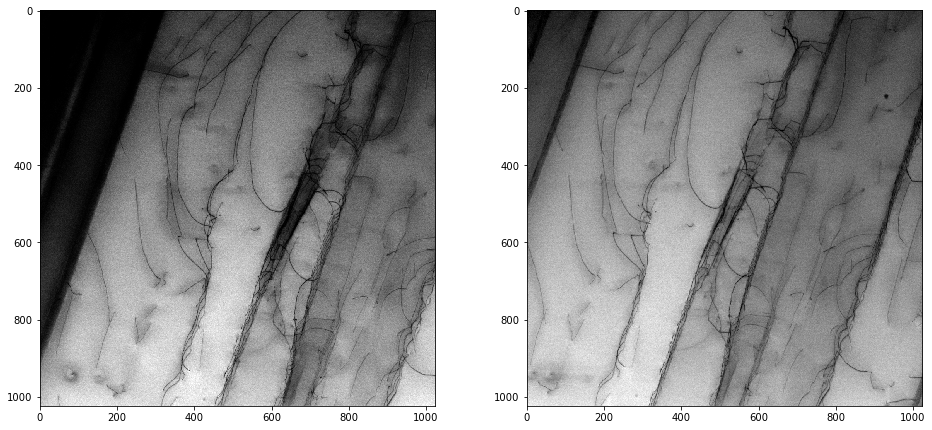

(1024, 1024)


In [3]:
# Read Stereo Pairs
imgL = cv2.imread('D:/Datasets/dislocations/Tilt Series/2019-12-02 TiAl box3n15/BF/1024x1024/2 1024x1024 a=-2.08 BF.tif',0)[:1024,:]
imgR = cv2.imread('D:/Datasets/dislocations/Tilt Series/2019-12-02 TiAl box3n15/BF/1024x1024/4 1024x1024 a=2.08 BF.tif',0)[:1024,:]

fig = plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.imshow(imgL, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(imgR, cmap='gray')
plt.show()
print(imgL.shape)

In [4]:
# Normalize and Wrap in Tensor
imgL_ts = torch.from_numpy(imgL).unsqueeze(0).unsqueeze(0) / 255.0
imgR_ts = torch.from_numpy(imgR).unsqueeze(0).unsqueeze(0) / 255.0
print(imgL_ts.shape)

torch.Size([1, 1, 1024, 1024])


# Segmentation

In [5]:
torch.cuda.empty_cache()

In [6]:
# Load Model
model_weights_path = "D:/Models/dislocations_remote/dislocations_segmentation/150_segmentor.tar"
input_channels = 1

model = UNet(input_channels).cuda()
state_dict = torch.load(model_weights_path)
model.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

In [7]:
# Predict
model.eval()
with torch.no_grad():
    seg_imgL_ts, seg_repL_ts = model(imgL_ts.cuda())
    seg_imgL_ts = torch.sigmoid(seg_imgL_ts)
    
    seg_imgR_ts, seg_repR_ts = model(imgR_ts.cuda())
    seg_imgR_ts = torch.sigmoid(seg_imgR_ts)

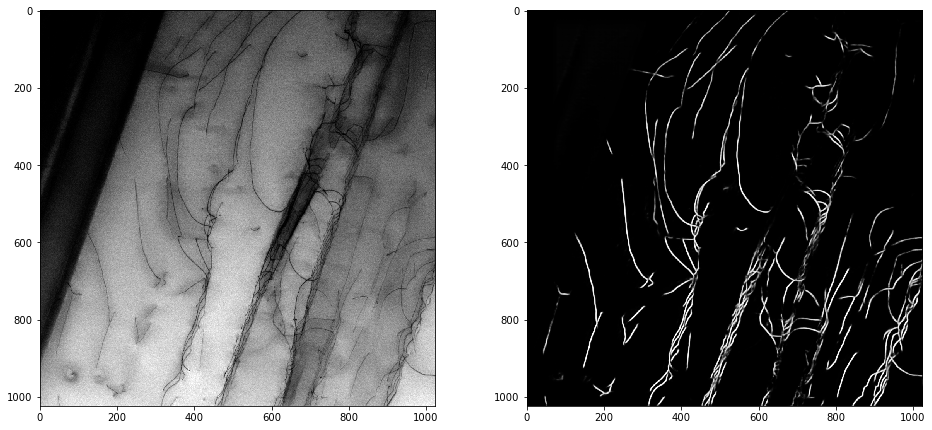

In [8]:
# Show Predictions
seg_imgL = seg_imgL_ts.squeeze().cpu().numpy()
seg_imgR = seg_imgR_ts.squeeze().cpu().numpy()

fig = plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.imshow(imgL, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(seg_imgL, cmap='gray')
plt.show()

# Alignment

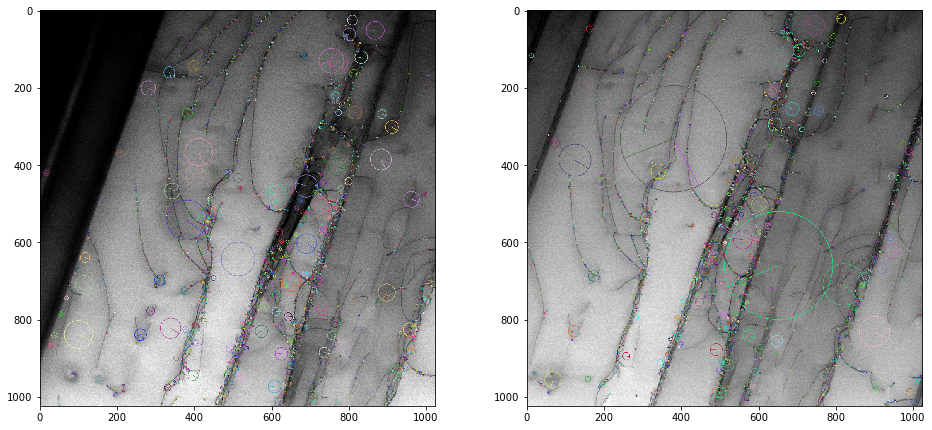

In [9]:
# Extract SIFT keypoints
sift = cv2.xfeatures2d.SIFT_create()
kpL, desL = sift.detectAndCompute(imgL,None)
kpR, desR = sift.detectAndCompute(imgR,None)

kpimgL=cv2.drawKeypoints(imgL,kpL,imgL,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kpimgR=cv2.drawKeypoints(imgR,kpR,imgR,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig = plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.imshow(kpimgL, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(kpimgR, cmap='gray')
plt.show()

In [10]:
# Match SIFT keypoints (FLANN)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desL,desR,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

[[ 1.00338658e+00 -3.81952771e-03 -1.33278573e+02]
 [ 3.81952771e-03  1.00338658e+00 -1.36790459e+01]]


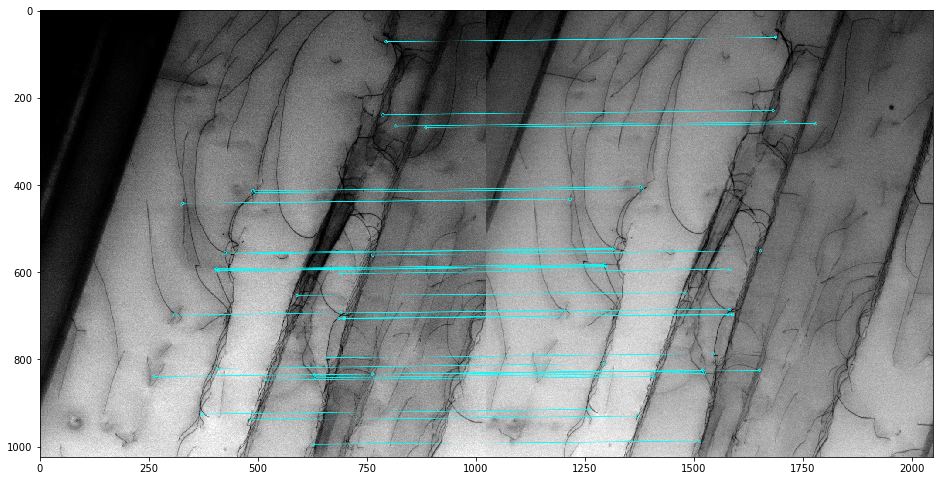

(<matplotlib.image.AxesImage at 0x17706c42940>, None)

In [11]:
# RANSAC to remove outliers
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kpL[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kpR[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)
    matchesMask = mask.ravel().tolist()
    
print(M)
draw_params = dict(matchColor = (0,255,255), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
match_img = cv2.drawMatches(imgL,kpL,imgR,kpR,good,None,**draw_params)

fig = plt.figure(figsize=(16, 16))
plt.imshow(match_img, 'gray'),plt.show()

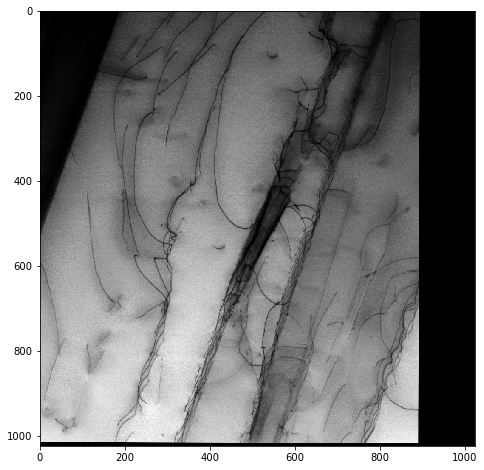

(<matplotlib.image.AxesImage at 0x17706bec278>, None)

In [12]:
warped_imgL = cv2.warpAffine(imgL, M, imgL.shape)
fig = plt.figure(figsize=(8, 8))
plt.imshow(warped_imgL, 'gray'),plt.show()

In [13]:
seg_repL = seg_repL_ts.squeeze().cpu().numpy().transpose(1,2,0)
warped_seg_repL = cv2.warpAffine(seg_repL, M, seg_repL.shape[:2])
warped_seg_repL_ts =  torch.from_numpy(warped_seg_repL.transpose(2,0,1)).unsqueeze(0)
print(warped_seg_repL_ts.shape)

torch.Size([1, 64, 1024, 1024])


# Matching

In [14]:
# Clean Unnecessery Tensors and Models
del model, imgL_ts, imgR_ts, seg_imgL_ts, seg_imgR_ts, seg_repL_ts
torch.cuda.empty_cache()

In [15]:
# Load Match Model
from delineation.utils import cost_volume_helpers

match_model_weights_path = "D:/Models/dislocations_remote/dislocations_matching_warping_new_var_loss_fixed/150_scmnet_light.tar"
input_channels, height, width = warped_seg_repL_ts.shape[1:]
nb_resblock = 2
nb_dispblock = 1
maxdisp = 32
disp_space = "two-sided"

match_model = SCMNET(input_channels, 1, [nb_resblock, nb_dispblock],
                     maxdisp, disp_space).cuda()

state_dict = torch.load(match_model_weights_path)
match_model.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

In [16]:
# Predict Disparity
match_model.eval()

indices = cost_volume_helpers.volume_indices(2 * maxdisp, 1, 512, 1024, torch.device("cpu"))
with torch.no_grad():
    scoresL = match_model(warped_seg_repL_ts.cuda()[:,:,100:612,:], seg_repR_ts[:,:,100:612,:])
    dispL = F.softmax(-scoresL, 2)
    dl = torch.sum(dispL.mul(indices.cuda()), 2) - 32
    
    print(dl.shape)

torch.Size([1, 1, 512, 1024])


In [17]:
dl = dl.squeeze().cpu().numpy()

In [100]:
# Custom Colormap
def cstm_viridis(x, mask):
    x_masked = x[mask]
    high = np.max(x_masked)
    low = np.min(x_masked)
    return plt.cm.viridis((np.clip(x,-32,32)-low)/(high-low)*1.0), high, low

Max disparity: 7.66
Min disparity: -6.24


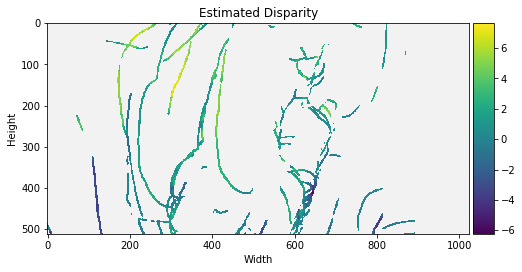

In [119]:
# Visualize Estimated Disparity
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot disparity
dl_mask = cv2.warpAffine(seg_imgL, M, seg_imgL.shape)[100:612,:]<0.10
dl_cmap, dmax, dmin = cstm_viridis(dl, ~dl_mask)
dl_cmap[dl_mask] = (0.95,0.95,0.95,1)
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.set_xlabel('Width')
ax.set_title('Estimated Disparity')
ax.set_ylabel('Height')
ax.imshow(dl_cmap)

# print disparity range
print("Max disparity: %.2f" % dmax)
print("Min disparity: %.2f" % dmin)

# add colorbar to plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cNorm =  matplotlib.colors.Normalize(vmin=dmin, vmax=dmax)
fig.colorbar(plt.cm.ScalarMappable(norm=cNorm, cmap='viridis'), cax=cax)

In [123]:
def compute_variance(dl, dl_prob, indices):
    var = torch.sum(torch.pow((indices - dl), 2).mul(dl_prob), 0)
    return var

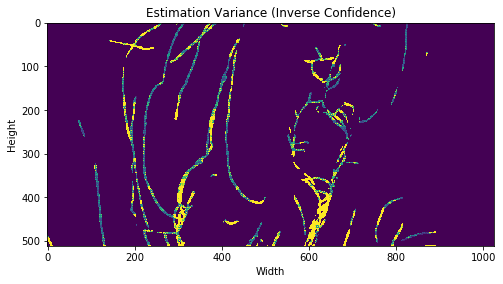

In [145]:
# Plot Confidences
dl_ts = torch.from_numpy(dl).unsqueeze(0) + 32
var = compute_variance(dl_ts, dispL.squeeze().cpu(), indices.squeeze().cpu())
var = var.squeeze().numpy()
var[dl_mask] = 0

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.set_xlabel('Width')
ax.set_title('Estimation Variance (Inverse Confidence)')
ax.set_ylabel('Height')
plt.imshow(var ,vmin=0, vmax=10)

# 3D Reconstruction